In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from tensorflow.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
from numpy.random import seed
from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GRU,LSTM,Dropout, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [3]:
df = pd.read_csv("21-12-21-datos.csv",
                 sep=";",
                 decimal=",",
                 parse_dates=['time_index'],
                 dayfirst=True,
                 index_col="time_index")

In [4]:
df

,temperature,relativehumidity,pm25,pm10,numberofincoming,numberofoutgoing,co2,ocupacion
time_index,,,,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,68.0,88.0,594.85,0.0
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,186.0,265.0,590.77,0.0
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,354.0,492.0,578.66,0.0
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,80.0,114.0,581.25,0.0
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,467.0,642.0,586.75,0.0
...,...,...,...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,0.0,0.0,409.35,0.0
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,0.0,0.0,408.84,0.0
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,0.0,0.0,408.72,0.0


In [5]:
df_final = df[['temperature', 'relativehumidity', 'pm25', 'pm10', 'co2']]
# df_final.reset_index(inplace=True, drop=True)
df_final

,temperature,relativehumidity,pm25,pm10,co2
time_index,,,,,
2021-09-27 10:00:00,27.34,49.74,11.88,13.00,594.85
2021-09-27 10:25:00,27.66,49.45,6.75,7.75,590.77
2021-09-27 10:30:00,27.94,49.70,5.38,6.38,578.66
2021-09-27 10:35:00,28.03,48.59,4.71,5.71,581.25
2021-09-27 10:40:00,28.09,48.43,3.62,4.62,586.75
...,...,...,...,...,...
2021-12-31 23:35:00,18.81,50.12,19.40,20.40,409.35
2021-12-31 23:40:00,18.82,50.13,19.80,20.80,408.84
2021-12-31 23:45:00,18.78,50.07,20.80,21.80,408.72


In [6]:
# Crea los lags de un df
def lags(dfOriginal, nLag):
    df = dfOriginal.copy()
    for i in df.columns:
        for j in range(1, (nLag+1)):
            palabra = i.split(' ', 1)[0]
            atributo = 'Lag_'+palabra+"_"+str(j)
            df[atributo] = df[i].shift(j)
    
    return df

In [9]:
df_lags = lags(df_final, 5) #predecir a 5 minutos

df_lags = df_lags[['Lag_temperature_1', 'Lag_temperature_2', 'Lag_temperature_3', 'Lag_temperature_4', 'Lag_temperature_5',
        'Lag_relativehumidity_1', 'Lag_relativehumidity_2', 'Lag_relativehumidity_3', 'Lag_relativehumidity_4', 'Lag_relativehumidity_5',
        'Lag_pm25_1', 'Lag_pm25_2', 'Lag_pm25_3', 'Lag_pm25_4', 'Lag_pm25_5',
        'Lag_pm10_1', 'Lag_pm10_2', 'Lag_pm10_3', 'Lag_pm10_4', 'Lag_pm10_5',
        'Lag_co2_1', 'Lag_co2_2', 'Lag_co2_3', 'Lag_co2_4', 'Lag_co2_5', 'co2']]

df_lags = df_lags.iloc[5:,:].reset_index(drop=True)
df_lags

,Lag_temperature_1,Lag_temperature_2,Lag_temperature_3,Lag_temperature_4,Lag_temperature_5,Lag_relativehumidity_1,Lag_relativehumidity_2,Lag_relativehumidity_3,Lag_relativehumidity_4,Lag_relativehumidity_5,...,Lag_pm10_2,Lag_pm10_3,Lag_pm10_4,Lag_pm10_5,Lag_co2_1,Lag_co2_2,Lag_co2_3,Lag_co2_4,Lag_co2_5,co2
0,28.09,28.03,27.94,27.66,27.34,48.43,48.59,49.70,49.45,49.74,...,5.71,6.38,7.75,13.00,586.75,581.25,578.66,590.77,594.85,579.95
1,28.06,28.09,28.03,27.94,27.66,48.02,48.43,48.59,49.70,49.45,...,4.62,5.71,6.38,7.75,579.95,586.75,581.25,578.66,590.77,609.86
2,25.93,28.06,28.09,28.03,27.94,51.06,48.02,48.43,48.59,49.70,...,4.62,4.62,5.71,6.38,609.86,579.95,586.75,581.25,578.66,616.17
3,25.96,25.93,28.06,28.09,28.03,50.89,51.06,48.02,48.43,48.59,...,31.75,4.62,4.62,5.71,616.17,609.86,579.95,586.75,581.25,617.56
4,25.99,25.96,25.93,28.06,28.09,50.76,50.89,51.06,48.02,48.43,...,36.88,31.75,4.62,4.62,617.56,616.17,609.86,579.95,586.75,620.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16845,18.82,18.82,18.83,18.86,18.87,50.07,50.06,50.07,50.08,50.06,...,19.70,19.10,18.50,18.50,409.86,409.15,408.77,408.92,409.00,409.35
16846,18.81,18.82,18.82,18.83,18.86,50.12,50.07,50.06,50.07,50.08,...,20.10,19.70,19.10,18.50,409.35,409.86,409.15,408.77,408.92,408.84
16847,18.82,18.81,18.82,18.82,18.83,50.13,50.12,50.07,50.06,50.07,...,20.40,20.10,19.70,19.10,408.84,409.35,409.86,409.15,408.77,408.72
16848,18.78,18.82,18.81,18.82,18.82,50.07,50.13,50.12,50.07,50.06,...,20.80,20.40,20.10,19.70,408.72,408.84,409.35,409.86,409.15,408.75


In [13]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_lags_norm = pd.DataFrame(scaler.fit_transform(df_lags), columns=df_lags.columns)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_lags_norm.iloc[:,:-1], df_lags_norm.iloc[:,-1:], 
                                                    test_size=0.3, 
                                                    random_state=seed_value,
                                                   shuffle=False)

In [16]:
X_train_timeseries = np.reshape(X_train.to_numpy(), (X_train.shape[0], 1, X_train.shape[1]))
X_test_timeseries = np.reshape(X_test.to_numpy(), (X_test.shape[0], 1, X_test.shape[1]))

In [18]:
model = Sequential()
model.add(LSTM(50, input_shape=X_train_timeseries.shape[1:], activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
    
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.fit(X_train_timeseries, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
369/369 - 2s - loss: 0.0036
Epoch 2/100
369/369 - 1s - loss: 8.2808e-04
Epoch 3/100
369/369 - 1s - loss: 7.0686e-04
Epoch 4/100
369/369 - 1s - loss: 6.4912e-04
Epoch 5/100
369/369 - 1s - loss: 5.5323e-04
Epoch 6/100
369/369 - 1s - loss: 5.4301e-04
Epoch 7/100
369/369 - 0s - loss: 5.1278e-04
Epoch 8/100
369/369 - 0s - loss: 4.9849e-04
Epoch 9/100
369/369 - 1s - loss: 4.7648e-04
Epoch 10/100
369/369 - 0s - loss: 4.6854e-04
Epoch 11/100
369/369 - 1s - loss: 4.6229e-04
Epoch 12/100
369/369 - 0s - loss: 4.5192e-04
Epoch 13/100
369/369 - 0s - loss: 4.4989e-04
Epoch 14/100
369/369 - 0s - loss: 4.3522e-04
Epoch 15/100
369/369 - 0s - loss: 4.3254e-04
Epoch 16/100
369/369 - 0s - loss: 4.1359e-04
Epoch 17/100
369/369 - 0s - loss: 4.2602e-04
Epoch 18/100
369/369 - 0s - loss: 4.1202e-04
Epoch 19/100
369/369 - 1s - loss: 4.1233e-04
Epoch 20/100
369/369 - 1s - loss: 4.1613e-04
Epoch 21/100
369/369 - 1s - loss: 3.9031e-04
Epoch 22/100
369/369 - 1s - loss: 4.0434e-04
Epoch 23/100
369/369 - 

In [39]:
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit_transform(df_lags['co2'].to_numpy().reshape(-1, 1))

array([[0.11537059],
       [0.13520809],
       [0.13939314],
       ...,
       [0.00180401],
       [0.00182391],
       [0.00236777]])

In [47]:
# make predictions
trainPredict = model.predict(X_train_timeseries)
testPredict = model.predict(X_test_timeseries)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.to_numpy())
testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.to_numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict.ravel()))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict.ravel()))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 14.92 RMSE
Test Score: 12.30 RMSE


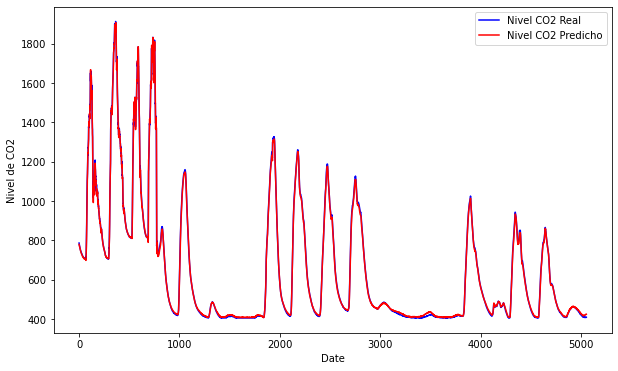

In [48]:
plt.figure(figsize=(10,6))
plt.plot(y_test, color='blue', label='Nivel CO2 Real')
plt.plot(testPredict , color='red', label='Nivel CO2 Predicho')
plt.xlabel('Date')
plt.ylabel('Nivel de CO2')
plt.legend()
plt.show()